# 01 - Embeddings Preparation

Notebook scope:
- load dataset/config via shared helpers
- build vocabulary and analyse coverage (Q1a/Q1b)
- prepare OOV mitigation experiments (Q1c)
- stage embedding visualisation workflow (Q1d)

_Heavy lifting stays in `src/`; this notebook should read like a report._


## Imports & dataset setup

Establish a consistent configuration-driven pipeline. Keep raw outputs minimal so plots/tables remain easy to lift into the final report.


In [4]:
from pathlib import Path
import dataclasses

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report, compute_oov_report, top_tokens_by_label
from src.plotting import plot_top_tokens_projection

base_config = load_data_config(Path("configs/data.yaml"))
coarse_config = dataclasses.replace(base_config, fine_grained=False)
fine_config = dataclasses.replace(base_config, fine_grained=True)

variants = {
    'coarse': {
        'config': coarse_config,
        'splits': prepare_tokenised_splits(coarse_config),
    },
    'fine': {
        'config': fine_config,
        'splits': prepare_tokenised_splits(fine_config),
    },
}

active_variant = 'fine'  # change to 'coarse' to switch views
data_config = variants[active_variant]['config']
splits = variants[active_variant]['splits']

len(splits.train), len(splits.validation), len(splits.test)


(4361, 1091, 500)

## Q1a - Vocabulary size

- Reuse `build_vocabulary_report` for corpus statistics.
- Persist intermediate artifacts (e.g., token frequencies) under `logs/` for reproducibility.


In [2]:
vocab_reports = {
    name: build_vocabulary_report(
        tokenised_dataset=variant['splits'].train,
        min_freq=variant['config'].vocabulary_min_freq,
        specials=variant['config'].vocabulary_specials,
    )
    for name, variant in variants.items()
}
vocab_report = vocab_reports[active_variant]
vocab_report.summary()


{'documents': 4361,
 'total_tokens': 45591,
 'unique_tokens': 7477,
 'vocabulary_size': 7479,
 'min_frequency_threshold': 1}

## Q1b - OOV analysis

- Compare vocabulary against chosen embedding index via `compute_oov_report`.
- Produce per-class OOV counts using the helper's `per_label_summary()`.


In [3]:
embedding_results = {}
oov_reports = {}
for name, variant in variants.items():
    vocab = vocab_reports[name].vocabulary
    embedding_results[name] = load_torchtext_glove(
        vocabulary=vocab,
        name="6B",
        dim=100,
        trainable=True,
        random_seed=7,
    )
    oov_reports[name] = compute_oov_report(
        tokenised_dataset=variant['splits'].train,
        special_tokens=variant['config'].vocabulary_specials,
        embedding_result=embedding_results[name],
    )

embedding_result = embedding_results[active_variant]
oov_report = oov_reports[active_variant]
oov_report.summary()


{'unique_oov_words': 197,
 'oov_token_occurrences': 215,
 'mitigated_vectors': 199}

In [4]:
oov_report.per_label_summary()


[{'label': 'ABBR:exp', 'unique_oov_words': 3, 'oov_token_occurrences': 4},
 {'label': 'DESC:def', 'unique_oov_words': 40, 'oov_token_occurrences': 40},
 {'label': 'DESC:desc', 'unique_oov_words': 11, 'oov_token_occurrences': 11},
 {'label': 'DESC:manner', 'unique_oov_words': 10, 'oov_token_occurrences': 10},
 {'label': 'DESC:reason', 'unique_oov_words': 10, 'oov_token_occurrences': 11},
 {'label': 'ENTY:animal', 'unique_oov_words': 3, 'oov_token_occurrences': 3},
 {'label': 'ENTY:color', 'unique_oov_words': 1, 'oov_token_occurrences': 1},
 {'label': 'ENTY:cremat', 'unique_oov_words': 10, 'oov_token_occurrences': 13},
 {'label': 'ENTY:dismed', 'unique_oov_words': 3, 'oov_token_occurrences': 3},
 {'label': 'ENTY:food', 'unique_oov_words': 5, 'oov_token_occurrences': 5},
 {'label': 'ENTY:other', 'unique_oov_words': 21, 'oov_token_occurrences': 21},
 {'label': 'ENTY:product', 'unique_oov_words': 3, 'oov_token_occurrences': 4},
 {'label': 'ENTY:sport', 'unique_oov_words': 3, 'oov_token_occu

### OOV distribution
Tabular view before plotting for clarity.


In [5]:
import pandas as pd

per_label_frames = {
    name: pd.DataFrame(report.per_label_summary())
    for name, report in oov_reports.items()
}
per_label_df = per_label_frames[active_variant]
per_label_df


,label,unique_oov_words,oov_token_occurrences
0,ABBR:exp,3,4
1,DESC:def,40,40
2,DESC:desc,11,11
3,DESC:manner,10,10
4,DESC:reason,10,11
5,ENTY:animal,3,3
6,ENTY:color,1,1
7,ENTY:cremat,10,13
8,ENTY:dismed,3,3
9,ENTY:food,5,5


### OOV histogram
Visualising per-label OOV occurrences.


/Users/petterollinen/GitHub/NLP_Project_group45/src/plotting.py:327: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


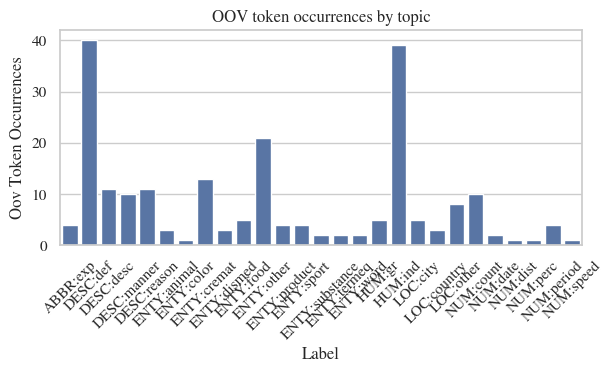

/Users/petterollinen/GitHub/NLP_Project_group45/src/plotting.py:327: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


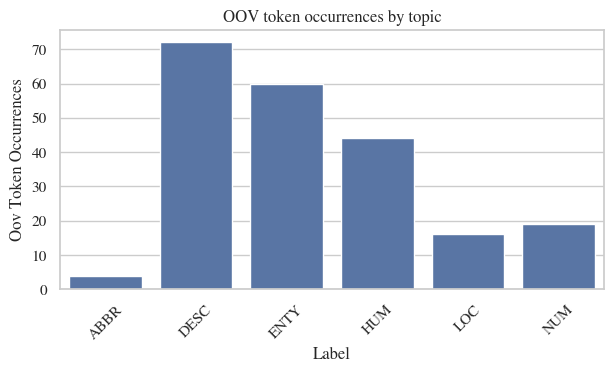

In [6]:
import matplotlib.pyplot as plt
from src.plotting import plot_oov_barplot

variant_to_plot = active_variant  # set to "coarse" to compare
fig_oov, ax_oov = plot_oov_barplot(per_label_frames[variant_to_plot], figure_fraction=1)
plt.show()

variant_to_plot = 'coarse'  # set to "coarse" to compare
fig_oov, ax_oov = plot_oov_barplot(per_label_frames[variant_to_plot], figure_fraction=1)
plt.show()


## Q1c - Mitigation strategy

- Compute the global mean of all in-vocabulary embeddings (excluding unknowns).
- Assign that mean vector to every OOV token before training.
- Keep the embeddings trainable.


In [7]:
from IPython.display import Markdown, display
mitigated_count = len(embedding_result.mitigated_tokens)
sample_tokens = list(embedding_result.mitigated_tokens.keys())[:10]
display(Markdown(f"Mitigated vectors generated for {mitigated_count} OOV tokens using the global mean. Example tokens: {', '.join(sample_tokens)}."))


Mitigated vectors generated for 199 OOV tokens using the global mean. Example tokens: -lantern, .., .dbf, 000th, 10-, 12601, 187s, 2th, 36893, 45mhz.

## Q1d - Embedding visualisation

- Use `plot_top_tokens_projection` to render scatter plots from the pre-computed token sets.
- Save figures under `plots/` for later inclusion in the report.


### Top tokens per topic
Preparing tokens for visualisation.


In [8]:
import seaborn as sns
from spacy.lang.en.stop_words import STOP_WORDS

top_tokens_map = {
    name: top_tokens_by_label(
        tokenised_dataset=variant['splits'].train,
        top_k=20,
        stopwords=set(STOP_WORDS),
    )
    for name, variant in variants.items()
}
coarse_labels = sorted(top_tokens_map["coarse"].keys())
coarse_palette = dict(zip(coarse_labels, sns.color_palette("tab10", n_colors=len(coarse_labels))))
fine_palette = {
    label: coarse_palette.get(label.split(":", 1)[0], "#999999")
    for label in top_tokens_map["fine"].keys()
}
label_palettes = {"coarse": coarse_palette, "fine": fine_palette}
legend_label_maps = {
    "coarse": {label: label for label in top_tokens_map["coarse"].keys()},
    "fine": {label: label.split(":", 1)[0] for label in top_tokens_map["fine"].keys()},
}
top_tokens = top_tokens_map[active_variant]


### PCA projection
Legend placed below to reduce clutter.


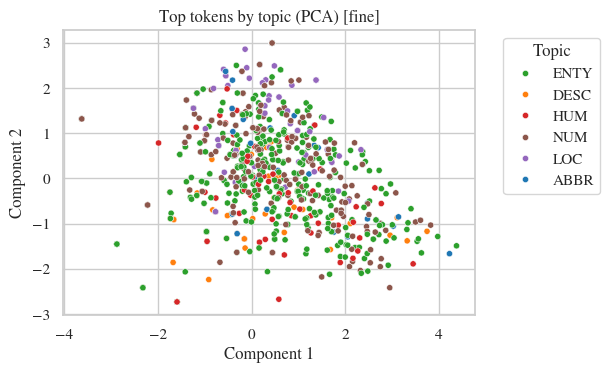

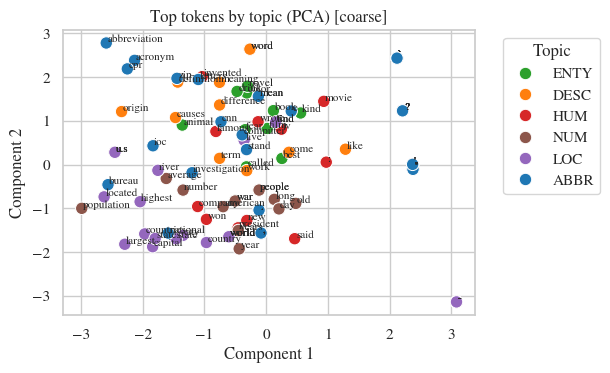

In [10]:
from src.plotting import plot_top_tokens_projection

variant_to_plot = active_variant  
projection_frame_pca, fig_pca, ax_pca = plot_top_tokens_projection(
    tokens_by_label=top_tokens_map[variant_to_plot],
    vocabulary=vocab_reports[variant_to_plot].vocabulary,
    embedding_matrix=embedding_results[variant_to_plot].matrix,
    method="pca",
    title=f"Top tokens by topic (PCA) [{variant_to_plot}]",
    output_path=Path(f"plots/part1_top_tokens_pca_{variant_to_plot}.png"),
    annotate_tokens=False,
    legend_location="right",
    figure_fraction=1,
    label_palette=label_palettes[variant_to_plot],
    legend_label_map=legend_label_maps[variant_to_plot],
    point_size=20
)


variant_to_plot = 'coarse'  
projection_frame_pca, fig_pca, ax_pca = plot_top_tokens_projection(
    tokens_by_label=top_tokens_map[variant_to_plot],
    vocabulary=vocab_reports[variant_to_plot].vocabulary,
    embedding_matrix=embedding_results[variant_to_plot].matrix,
    method="pca",
    title=f"Top tokens by topic (PCA) [{variant_to_plot}]",
    output_path=Path(f"plots/part1_top_tokens_pca_{variant_to_plot}.png"),
    annotate_tokens=True,
    legend_location="right",
    figure_fraction=1,
    label_palette=label_palettes[variant_to_plot],
    legend_label_map=legend_label_maps[variant_to_plot],
    point_size = 80
)


### t-SNE projection
Lower-dimensional view via t-SNE (perplexity 20).


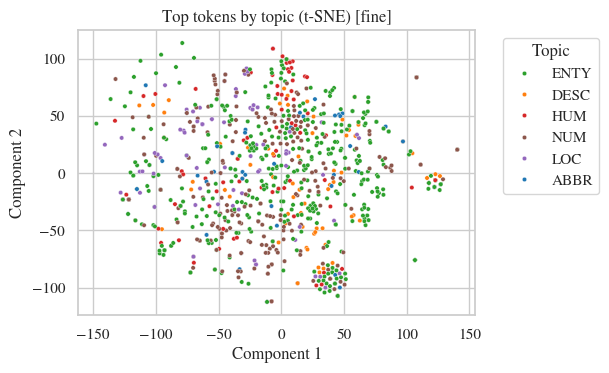

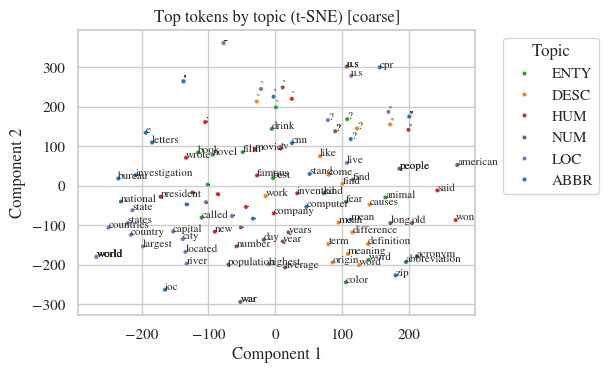

In [14]:
from src.plotting import plot_top_tokens_projection

variant_to_plot = active_variant
projection_frame_tsne, fig_tsne, ax_tsne = plot_top_tokens_projection(
    tokens_by_label=top_tokens_map[variant_to_plot],
    vocabulary=vocab_reports[variant_to_plot].vocabulary,
    embedding_matrix=embedding_results[variant_to_plot].matrix,
    method="tsne",
    title=f"Top tokens by topic (t-SNE) [{variant_to_plot}]",
    output_path=Path(f"plots/part1_top_tokens_tsne_{variant_to_plot}.png"),
    annotate_tokens=False,
    legend_location="right",
    tsne_perplexity=15.0,
    figure_fraction=1,
    label_palette=label_palettes[variant_to_plot],
    legend_label_map=legend_label_maps[variant_to_plot],
    point_size=10
)

variant_to_plot = 'coarse'
projection_frame_tsne, fig_tsne, ax_tsne = plot_top_tokens_projection(
    tokens_by_label=top_tokens_map[variant_to_plot],
    vocabulary=vocab_reports[variant_to_plot].vocabulary,
    embedding_matrix=embedding_results[variant_to_plot].matrix,
    method="tsne",
    title=f"Top tokens by topic (t-SNE) [{variant_to_plot}]",
    output_path=Path(f"plots/part1_top_tokens_tsne_{variant_to_plot}.png"),
    annotate_tokens=True,
    legend_location="right",
    tsne_perplexity=15.0,
    figure_fraction=1,
    label_palette=label_palettes[variant_to_plot],
    legend_label_map=legend_label_maps[variant_to_plot],
    point_size=10
)
